# Ejercicio 3 – Predicción de series temporales con Prophet

## ¿Qué es Prophet?

**Prophet** es una herramienta desarrollada por Facebook para facilitar el modelado de series temporales, especialmente útil cuando:

- Hay **tendencias y estacionalidades** claras.
- Hay **festivos o eventos especiales**.
- Se necesita una **herramienta sencilla pero flexible** sin profundos conocimientos estadísticos.

Es muy utilizado en contextos empresariales y educativos por su simplicidad y eficacia.

## ¿Cómo funciona?

Prophet descompone la serie en tres componentes principales:

\[
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
\]

- `g(t)`: Tendencia (lineal, logística, piecewise)
- `s(t)`: Estacionalidad (diaria, semanal, anual)
- `h(t)`: Festivos o eventos especiales
- `ε`: Error aleatorio

---

## Flujo de trabajo

```mermaid
flowchart TD
    A[Dataset original] --> B[Renombrar columnas: ds, y]
    B --> C[Modelo Prophet básico]
    C --> D[Predicción futura]
    D --> E[Visualización]
    E --> F[Modelo con regresores externos]
    F --> G[Comparación de rendimiento]
```

---

## Requisitos previos
```bash
pip install prophet
```

---

## Parte 1 – Modelo Prophet

### Paso 1: Preparar el dataset

In [41]:
from prophet import Prophet
import pandas as pd

# Cargar y preparar datos
df = pd.read_csv("data/m5_consumo_energia_train.csv", index_col=0)
df = df.set_index(pd.to_datetime(df.index))

df['dt'] = df.index

# Prophet requiere columnas: 'ds' para fecha y 'y' para valor
train_df = df.rename(columns={"dt": "ds", "Energia Consumida": "y"})

In [42]:
val_df = pd.read_csv("data/m5_consumo_energia_test.csv", index_col=0)
val_df = val_df.set_index(pd.to_datetime(val_df.index))
val_df['dt'] = val_df.index
val_df = val_df.rename(columns={"dt": "ds", "Energia Consumida": "y"})

---

### Paso 2: Crear y entrenar el modelo

In [44]:
m = Prophet()
m.fit(train_df)

22:37:49 - cmdstanpy - INFO - Chain [1] start processing
22:37:50 - cmdstanpy - INFO - Chain [1] done processing


---

### Paso 3: Crear futuro y predecir

In [51]:
# Predecir los próximos 30 días
future = m.make_future_dataframe(periods=len(val_df))
forecast = m.predict(future)

---

### Paso 4: Visualizar resultado

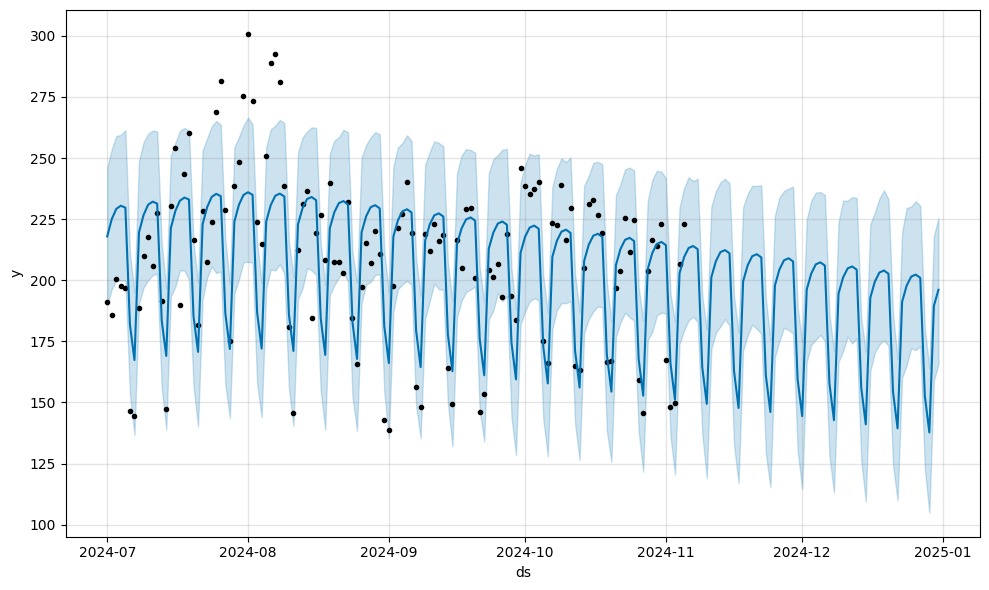

In [52]:
fig1 = m.plot(forecast)

#### Explicación

Este es el **gráfico principal de predicción de Prophet**. Incluye:

- La **serie original** (línea negra o puntos).
- La **predicción** realizada por el modelo (línea azul).
- Un **intervalo de confianza del 95%** alrededor de la predicción (franja azul claro).

🔍 **Interpretación**:
- La línea azul continúa donde termina la serie original y muestra el valor estimado para los días futuros.
- El área azul claro indica la **incertidumbre** del modelo en cada punto futuro (más ancho = más incertidumbre).

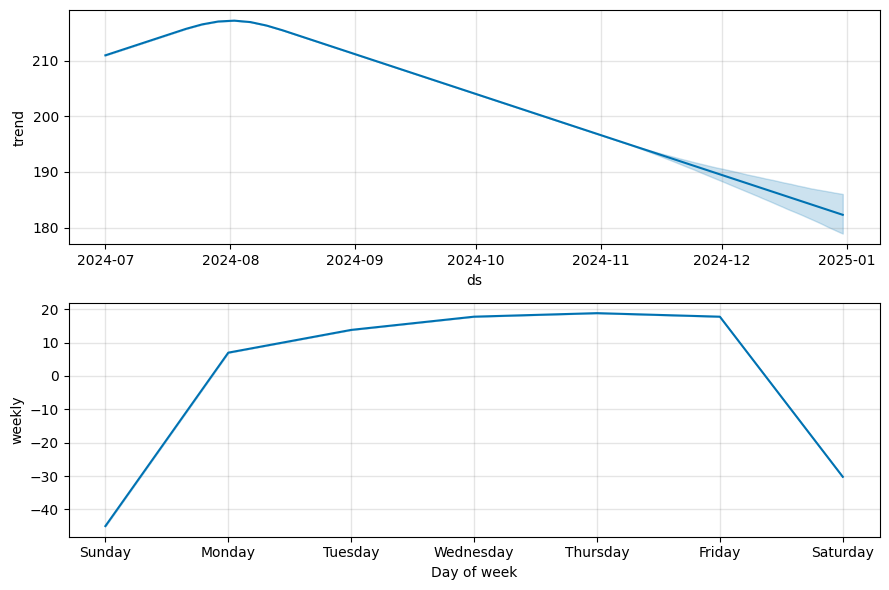

In [53]:
fig2 = m.plot_components(forecast)

### Explicación

Este genera **una visualización separada de los componentes del modelo Prophet**:

1. **Tendencia (trend)**:  
   La evolución a largo plazo del consumo.  
   Puedes ver si hay una subida, bajada, o tramos con crecimientos distintos.

2. **Estacionalidad semanal** (si existe):  
   Cómo varía el consumo según el día de la semana (por ejemplo, más consumo entre semana que los fines de semana).

3. **Estacionalidad anual** (si hay suficientes datos):  
   Fluctuaciones repetitivas a lo largo del año (más relevante con >1 año de datos).

4. **Otros componentes**:  
   Si has añadido **regresores** o **festivos**, también se incluirán aquí.

🔍 **Interpretación**:
- Este gráfico permite entender **qué patrones ha aprendido el modelo**, más allá de la predicción final.
- Es ideal para explicar el comportamiento estacional a otras personas no técnicas.

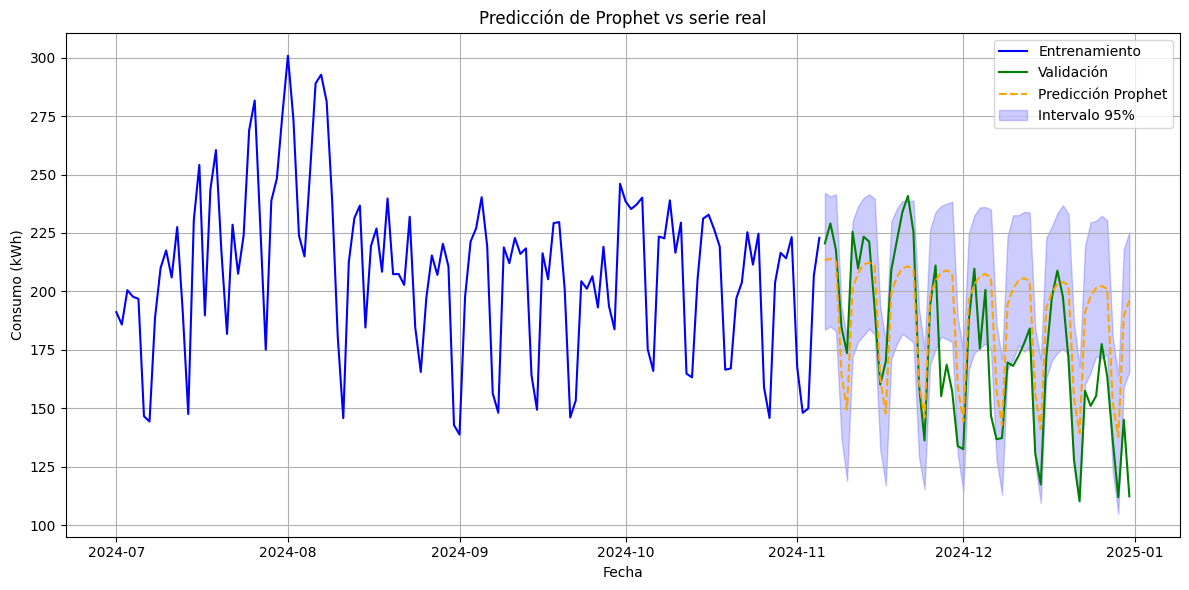

In [54]:
import matplotlib.pyplot as plt

# También puedes obtener el final de train como referencia
cutoff_date = train_df["ds"].max()

# Filtramos la parte futura del forecast
forecast_future = forecast[forecast["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validación", color="green")

# Predicción
plt.plot(forecast_future["ds"], forecast_future["yhat"], label="Predicción Prophet", color="orange", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_future["ds"],
                 forecast_future["yhat_lower"],
                 forecast_future["yhat_upper"],
                 color="blue", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicción de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el rendimiento del modelo

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_future["yhat"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 22.65
RMSE: 27.93


---

## Parte 2 – Modelado con regresores externos

Un **regresor** es una variable adicional que se incluye en el modelo para ayudar a explicar las variaciones del valor que queremos predecir.

En el contexto de consumo de energía, algunos ejemplos de regresores pueden ser:

- Temperatura (afecta al uso de aire acondicionado o calefacción)
- Humedad (relacionada con el uso de sistemas de ventilación o agua)
- Día de la semana (influye en el comportamiento de consumo en edificios)

### ¿Qué aporta un regresor?
**Mejora la precisión del modelo**
Al introducir una variable que está correlacionada con la serie temporal, el modelo puede anticiparse mejor a ciertos cambios o fluctuaciones que no se explican solo con el tiempo.

**Captura relaciones causales**
Un regresor puede reflejar una relación de causa y efecto real. Por ejemplo, sabemos que a mayor temperatura, probablemente aumenta el consumo energético por el uso de aire acondicionado.

**Permite simular escenarios**
Si el modelo incluye regresores, podemos simular “¿qué pasaría si...?” variara la temperatura o la humedad, lo que es útil para escenarios educativos o de planificación.

**Reduce el error**
En muchos casos, incluir regresores mejora métricas como MAE o RMSE, porque el modelo puede explicar parte del comportamiento que antes consideraba “ruido”.

### Paso 1: Visualizar correlaciones

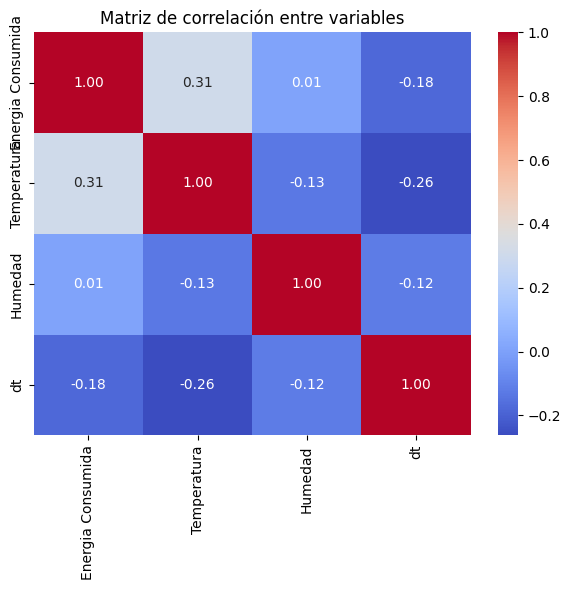

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de correlación
corr = df.corr()

# Representar heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de correlación entre variables")
plt.tight_layout()
plt.show()

### Paso 2: Añadir regresores al dataframe

In [96]:
# Preparar dataset con variables externas (Temperatura y Humedad)
train_reg_df = df.reset_index().rename(columns={
    "dt": "ds",
    "Energia Consumida": "y"
})

# Añadir regresores
train_reg_df["temperatura"] = df["Temperatura"].values
train_reg_df["humedad"] = df["Humedad"].values

---

### Paso 3: Definir modelo con regresores

In [73]:
m_reg = Prophet()
m_reg.add_regressor("temperatura")
# m_reg.add_regressor("humedad")

m_reg.fit(train_reg_df)

22:53:13 - cmdstanpy - INFO - Chain [1] start processing
22:53:13 - cmdstanpy - INFO - Chain [1] done processing


---

### Paso 3: Crear futuro con regresores

In [87]:
all_df = pd.concat([train_df, val_df], axis=0)
all_df

,y,Temperatura,Humedad,ds
2024-07-01,191.15,21.710,76.765,2024-07-01
2024-07-02,185.83,21.969,73.388,2024-07-02
2024-07-03,200.53,22.129,73.098,2024-07-03
2024-07-04,197.76,22.161,75.965,2024-07-04
2024-07-05,196.79,21.929,76.122,2024-07-05
...,...,...,...,...
2024-12-27,163.73,18.800,70.509,2024-12-27
2024-12-28,136.40,19.817,63.528,2024-12-28
2024-12-29,111.97,19.278,69.048,2024-12-29
2024-12-30,145.13,18.613,64.812,2024-12-30


In [ ]:
# Generar mismo número de días futuros
future_reg = m_reg.make_future_dataframe(periods=len(val_df))
future_reg = future_reg.set_index(pd.to_datetime(future_reg['ds']))
# Aquí usamos el valor real de cada variable meteorológica
future_reg["temperatura"] = all_df['Temperatura']
# future_reg["humedad"] = list(df["Humedad"].values) + [df["Humedad"].values[-1]]*len(val_df)

In [89]:
future_reg

,ds,temperatura
ds,,
2024-07-01,2024-07-01,21.710
2024-07-02,2024-07-02,21.969
2024-07-03,2024-07-03,22.129
2024-07-04,2024-07-04,22.161
2024-07-05,2024-07-05,21.929
...,...,...
2024-12-27,2024-12-27,18.800
2024-12-28,2024-12-28,19.817
2024-12-29,2024-12-29,19.278


---

### Paso 4: Predecir y visualizar

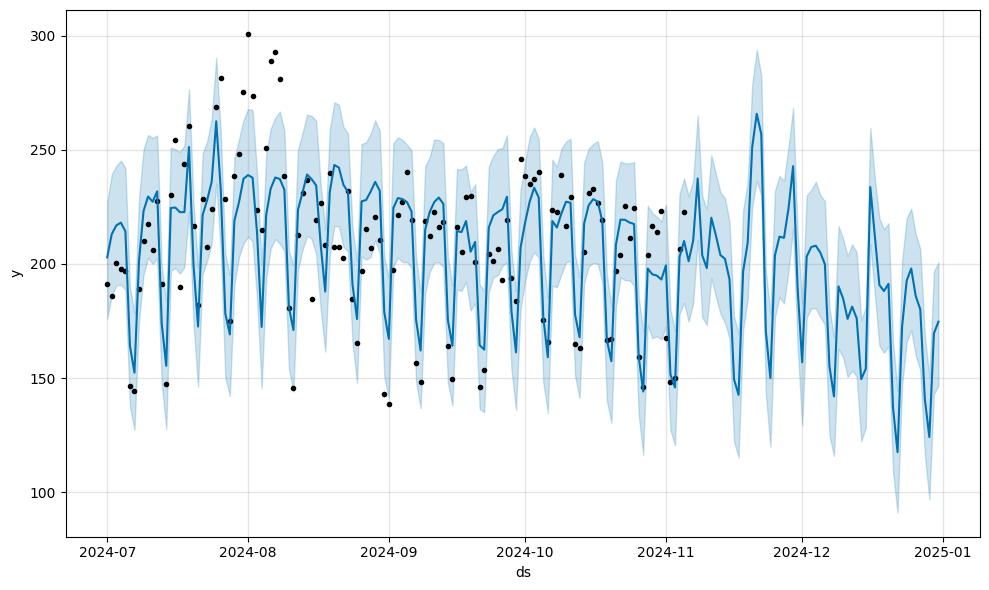

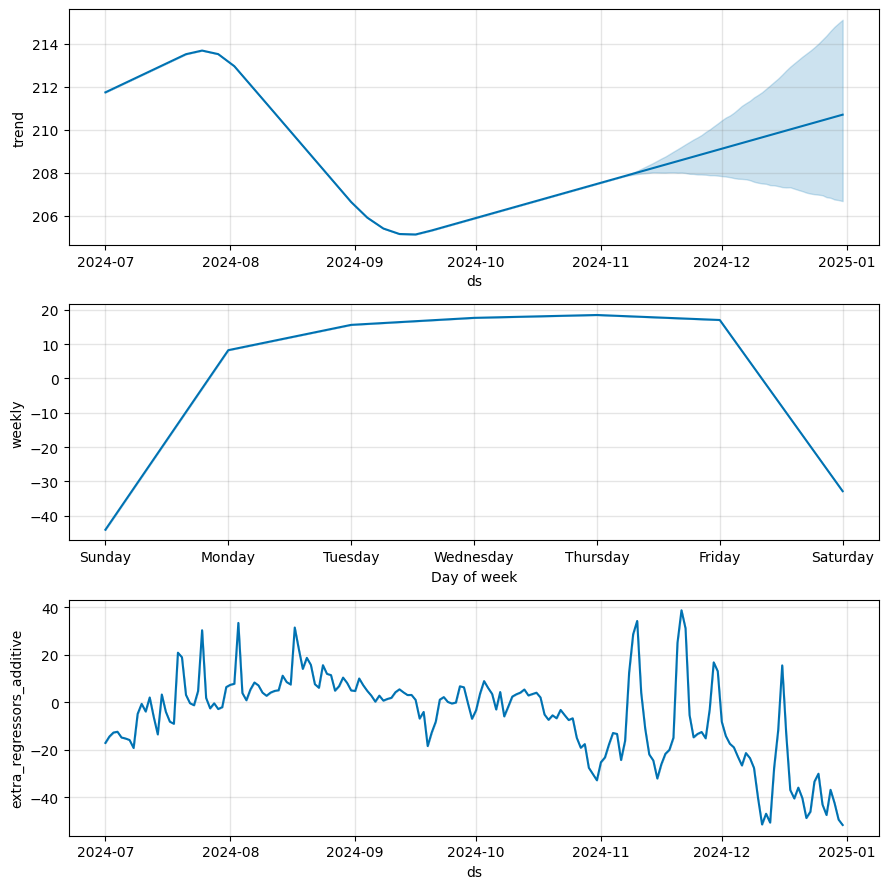

In [90]:
forecast_reg = m_reg.predict(future_reg)

# Visualización
fig1 = m_reg.plot(forecast_reg)
fig2 = m_reg.plot_components(forecast_reg)

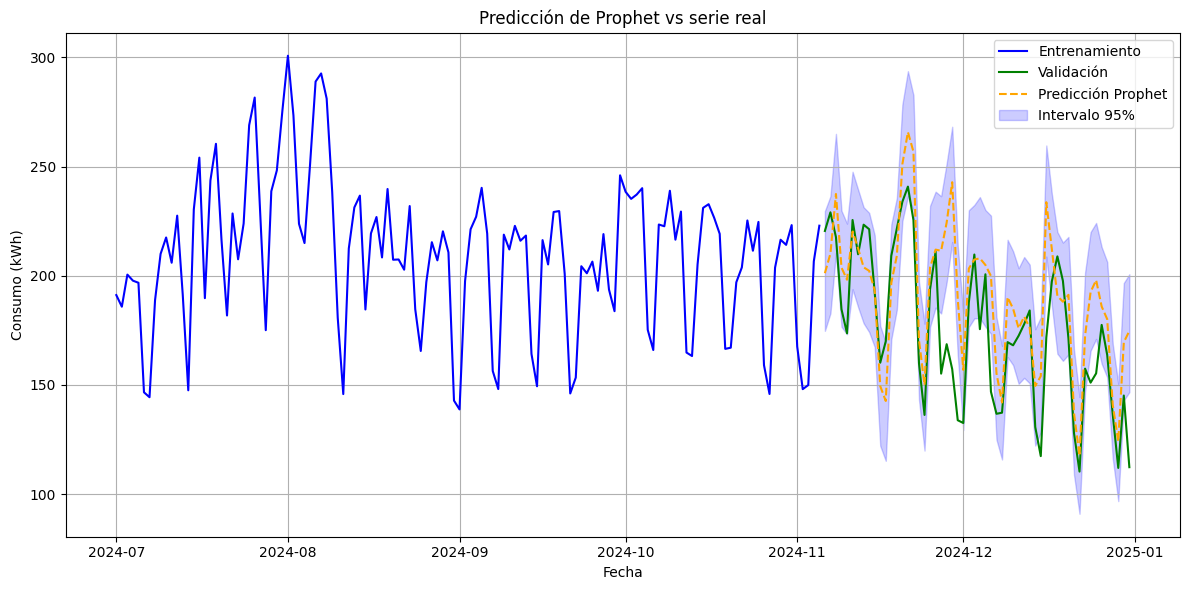

In [93]:
import matplotlib.pyplot as plt

# También puedes obtener el final de train como referencia
cutoff_date = train_df["ds"].max()

# Filtramos la parte futura del forecast
forecast_reg_future = forecast_reg[forecast_reg["ds"] > cutoff_date]

# Graficamos todo
plt.figure(figsize=(12, 6))

# Serie real
plt.plot(train_df["ds"], train_df["y"], label="Entrenamiento", color="blue")
plt.plot(val_df["ds"], val_df["y"], label="Validación", color="green")

# Predicción
plt.plot(forecast_reg_future["ds"], forecast_reg_future["yhat"], label="Predicción Prophet", color="orange", linestyle="--")

# Intervalo de confianza
plt.fill_between(forecast_reg_future["ds"],
                 forecast_reg_future["yhat_lower"],
                 forecast_reg_future["yhat_upper"],
                 color="blue", alpha=0.2, label="Intervalo 95%")

# Formato
plt.title("Predicción de Prophet vs serie real")
plt.xlabel("Fecha")
plt.ylabel("Consumo (kWh)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

### Paso 5: Evaluar el modelo

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(val_df["y"], forecast_reg_future["yhat"])
rmse = np.sqrt(mean_squared_error(val_df["y"], forecast_reg_future["yhat"]))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 21.52
RMSE: 28.15


---

## ✅ Resultado esperado

- Preparar tus datos en formato adecuado para Prophet.
- Entrenar modelos con y sin regresores externos.
- Visualizar tendencias, estacionalidades y componentes.
- Comparar predicciones y detectar el efecto de variables como temperatura o humedad.